Parkinson Prediction using Random Forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.metrics import classification_report, balanced_accuracy_score, ConfusionMatrixDisplay, make_scorer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt

In [2]:
#merged_file = pd.read_csv("Data/gene_matrix.csv")
gene_demo_file = pd.read_csv("merged_all.csv")
merged_file = gene_demo_file.dropna()
print("Original shape:", gene_demo_file.shape)
print("Cleaned shape :", merged_file.shape)

null_counts = merged_file.isna().sum()
print(null_counts[null_counts > 0].sort_values(ascending=False))
print(merged_file["GENDER"].unique())
print(merged_file["GENDER"].value_counts(dropna=False))

Original shape: (712, 119)
Cleaned shape : (712, 119)
Series([], dtype: int64)
['Female' 'Male']
GENDER
Male      435
Female    277
Name: count, dtype: int64


In [3]:
nhy_map = {0:0,1:1,2:1,3:1,4:1,5:1}
merged_file.loc[:,"NHY_MAPPED"] = merged_file["NHY"].map(nhy_map)
target_col = "NHY_MAPPED"
merged_file.loc[:,"GENDER_MAPPED"] = merged_file["GENDER"].map({"Male": 0, "Female": 1})


DEMOGRAPHICS ONLY

In [4]:
cols_to_include = ["GENDER_MAPPED","AGE","EDUC_YRS"]
feature_cols_demo = merged_file.columns.intersection(cols_to_include)
X_demo = merged_file[feature_cols_demo]
y = merged_file[target_col]
print("X shape:", X_demo.shape)
print("y shape:", y.shape)

X shape: (712, 3)
y shape: (712,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_demo, y, test_size=0.2, stratify=y, random_state=42
)
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.555 ± 0.036


In [6]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]   

# Evaluate
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Asymptomatic (0)", "PD (1)"]))

Balanced Accuracy: 0.499692118226601
                  precision    recall  f1-score   support

Asymptomatic (0)       0.39      0.48      0.43        56
          PD (1)       0.61      0.52      0.56        87

        accuracy                           0.50       143
       macro avg       0.50      0.50      0.50       143
    weighted avg       0.52      0.50      0.51       143



DEMOGRAPHICS + MRI ONLY

In [7]:
cols_to_include = ["GENDER_MAPPED","AGE","EDUC_YRS","lh_MeanThickness","lh_WhiteSurfArea","lhCerebralWhiteMatterVol","Left_Cerebellum_White_Matter","CerebralWhiteMatterVol","lhSurfaceHoles"]
feature_cols_demo_mri = merged_file.columns.intersection(cols_to_include)
X_demo_mri = merged_file[feature_cols_demo_mri]
y = merged_file[target_col]
print("X shape:", X_demo_mri.shape)
print("y shape:", y.shape)

X shape: (712, 9)
y shape: (712,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_demo_mri, y, test_size=0.2, stratify=y, random_state=42
)
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.538 ± 0.050


In [9]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]   

# Evaluate
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Asymptomatic (0)", "PD (1)"]))

Balanced Accuracy: 0.5099548440065682
                  precision    recall  f1-score   support

Asymptomatic (0)       0.40      0.41      0.41        56
          PD (1)       0.62      0.61      0.61        87

        accuracy                           0.53       143
       macro avg       0.51      0.51      0.51       143
    weighted avg       0.53      0.53      0.53       143



DEMOGRAPHICS + MRI + GENE

In [10]:
cols_to_exclude = ["PATNO","EVENT_ID","NHY","NHY_MAPPED","GENDER","NHY_BL","MRIRSLT","rh_MeanThickness","rh_WhiteSurfArea","rhCerebralWhiteMatterVol","Right_Cerebellum_White_Matter","CerebralWhiteMatterVol","rhSurfaceHoles"]
feature_cols = merged_file.columns.difference(cols_to_exclude)
X = merged_file[feature_cols]
y = merged_file[target_col]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (712, 108)
y shape: (712,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
#selector = SelectKBest(score_func=f_classif, k=50)
#X_train_selected = selector.fit_transform(X_train, y_train)
#X_test_selected = selector.transform(X_test)
#selected_genes = X.columns[selector.get_support()]
#print(selected_genes[:50])
pipeline = ImbPipeline([
    ("scale", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train,
    cv=cv,
    scoring=make_scorer(balanced_accuracy_score),
    n_jobs=-1
)

print(f"CV balanced accuracy (train): {scores.mean():.3f} ± {scores.std():.3f}")

CV balanced accuracy (train): 0.555 ± 0.031


ROC CURVE

ROC-AUC: 0.704


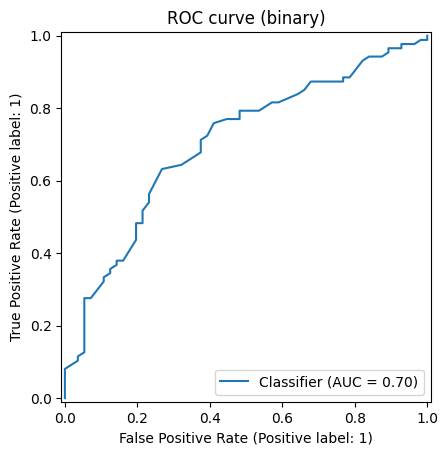

Balanced Accuracy: 0.6554802955665024
                  precision    recall  f1-score   support

Asymptomatic (0)       0.62      0.52      0.56        56
          PD (1)       0.72      0.79      0.75        87

        accuracy                           0.69       143
       macro avg       0.67      0.66      0.66       143
    weighted avg       0.68      0.69      0.68       143



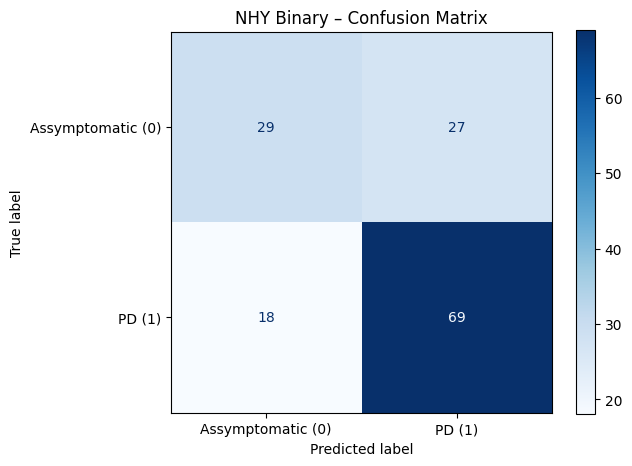

In [12]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]   
roc_auc = roc_auc_score(y_test, y_prob)

print(f"ROC-AUC: {roc_auc:.3f}")

# Optional: plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC curve (binary)")
plt.show()

# Evaluate
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Asymptomatic (0)", "PD (1)"]))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Assymptomatic (0)", "PD (1)"], cmap="Blues")
plt.title("NHY Binary – Confusion Matrix")
plt.tight_layout()
plt.show()